In [2]:
##############################################################################################################################
##############################################################################################################################
#
#       CMPT 353 FINAL PROJECT:
#       This script performs post hoc analysis on the view count of 
#       trending YouTube videos for the periods of pre (2018) and during (2020) COVID-19.
#       
#       Please reference the README file for a full guide on how to build this script, but look below
#       for a quick start guide.
#
#       This analysis runs for the following countries:
#
#       Country                 Command
#
#       Canada                  Python3 Trending_Video_Views_Analysis.py CA
#       USA                     Python3 Trending_Video_Views_Analysis.py US
#       Great Britain           Python3 Trending_Video_Views_Analysis.py GB
#
##############################################################################################################################
##############################################################################################################################

### Libraries

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from time import sleep
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sys
import datetime as dt
import datetime as dt

### Helper Functions

In [4]:

# Helper function used to convert the video category file for 2018 data to a valid Dataframe object
# with specified column names.
def convert_json_cats_to_pandas_2018(json_dir):
    
    # Read in the json data
    with open(json_dir) as f:
        cat_data = json.load(f)

    # define the dataframe column names + series for each name
    cat = {'category_id': [], 'cat_name': []}

    # Parse through the json data and add key values to dataframe object
    for i in cat_data['items']:
        cat['category_id'].append(i['id'])
        cat['cat_name'].append(i['snippet']['title'])

    # define the dataframe object and add data to it
    df = pd.DataFrame(data = cat)

    return(df)


# Helper function used to merge 2018 video data and category data into a valid Dataframe object
# NOTE: This function should only be used for 2018 YouTube videos
def get_merged_data_2018(vids_dir, cats_dir):

    # Import the compressed csv file
    vids_df = pd.read_csv(vids_dir)

    # Subset to only include first 4 months of 2018
    vids_df['trending_date'] =  pd.to_datetime(vids_df['trending_date'], format='%y.%d.%m')
    vids_df = vids_df[vids_df['trending_date'].dt.strftime('%Y') == '2018']
    vids_df = vids_df[vids_df['trending_date'].dt.strftime('%m') < '05'].reset_index()

    # Load category file
    cats_df = convert_json_cats_to_pandas_2018(cats_dir)
    cats_df['category_id'] = cats_df['category_id'].astype(int)

    # Merge video and category dataframes to get the full data
    all_vid_data = pd.merge(vids_df, cats_df, on='category_id')

    # Group by category + count keys in each category
    daily_cats = all_vid_data.groupby('cat_name').agg(['count'])['video_id'].reset_index()

    return(daily_cats)


# Helper function used to convert the video category file for 2020 data to a valid Dataframe object
# with specified column names.
def convert_json_cats_to_pandas_2020(json_dir):
    
    # Load in the categories
    with open(json_dir) as f:
        cat_data = json.load(f)

    # define the dataframe column names + series for each name    
    cat = {'categoryId': [], 'cat_name': []}

    # Parse through the json data and add key values to dataframe object
    for i in cat_data['items']:
        cat['categoryId'].append(i['id'])
        cat['cat_name'].append(i['snippet']['title'])

    # define the dataframe object and add data to it
    df = pd.DataFrame(data = cat)

    return(df)


# Helper function used to merge 2018 video data and category data into a valid Dataframe object
# NOTE: This function should only be used for 2020 YouTube videos
def get_merged_data_2020(vids_dir, cats_dir):

    # Import the compressed csv file
    vids_df = pd.read_csv(vids_dir)

    # Load category file
    cats_df = convert_json_cats_to_pandas_2020(cats_dir)
    cats_df['categoryId'] = cats_df['categoryId'].astype(int)

    # Merge video and category dataframes to get the full data
    all_vid_data = pd.merge(vids_df, cats_df, on='categoryId')

    # Group by category + count keys in each category
    daily_cats = all_vid_data.groupby('cat_name').agg(['count'])['video_id'].reset_index()

    return(daily_cats)


# Helper function used to plot the count of video categories for 2018 vs 2020.
def create_barplot(df, country):

    # derive useful columns
    cats       = df['cat_name']
    count_2018 = df['count_2018']
    count_2020 = df['count_2020']

    # Create the y position of the plot
    ypos = np.arange(len(cats))

    # Set the figure margins
    plt.figure(figsize=(10,15))

    # Create bars at specified locations
    plt.bar(ypos-0.2, count_2018, width=0.4, label='2018 Count', color='red')
    plt.bar(ypos+0.2, count_2020, width=0.4, label='2020 Count', color='blue')
    plt.xticks(ypos, cats)
    plt.xticks(rotation=90)
    plt.ylabel('Trending Count')    
    plt.legend()
    plt.ylabel('Count')

    # Create the title of the barplot
    title = str(country) + ' - Trending Youtube Video Count'
    plt.title(title)

    # Save file to local workiing directory
    file_title = title + '.png'
    plt.savefig(file_title, dpi=100)


# Helper function used to get the individual views of trending videos in 2018
# NOTE: This function should only be used for the 2018 dataset
def get_view_data_2018(vids_dir, cats_dir):

    # Import the video trending data
    vids_df = pd.read_csv(vids_dir)

    # Subset data to only include first 4 months of 2018
    vids_df['trending_date'] =  pd.to_datetime(vids_df['trending_date'], format='%y.%d.%m')
    vids_df = vids_df[vids_df['trending_date'].dt.strftime('%Y') == '2018']
    vids_df = vids_df[vids_df['trending_date'].dt.strftime('%m') < '05'].reset_index()    

    # Load category file
    cats_df = convert_json_cats_to_pandas_2018(cats_dir)
    cats_df['category_id'] = cats_df['category_id'].astype(int)

    # Merge video and category dataframes
    all_vid_data = pd.merge(vids_df, cats_df, on='category_id')
    
    # Return only relevant data values
    return(all_vid_data[['cat_name', 'views']])


# Helper function used to get the individual views of trending videos in 2020
# NOTE: This function should only be used for the 2020 dataset
def get_view_data_2020(vids_dir, cats_dir):

    # Import the video trending data
    vids_df = pd.read_csv(vids_dir)

    # Load category file
    cats_df = convert_json_cats_to_pandas_2020(cats_dir)
    cats_df['categoryId'] = cats_df['categoryId'].astype(int)

    # Merge video and category dataframes
    all_vid_data = pd.merge(vids_df, cats_df, on='categoryId')

    # Return only relevant data values
    ret = all_vid_data[['cat_name', 'view_count']].rename(columns={'view_count': 'views'})
    return(ret)


# Plot hustogram of views per category of inputted dataframe
def plot_views_hist(data_per_year, country, year, transformed):

    # Create plot axis
    fig, ax = plt.subplots(figsize=(10,7))
    for label, df in data_per_year.groupby('cat_name'):
        df.views.plot(kind="hist", ax=ax, label=label)
        
    plt.legend()

    # Create the title of the barplot
    title = str(country) + ' - Histogram of Views per category (' + str(year) + ')'
    if(transformed):
        title += '(Transformed)'
    plt.title(title)

    # Save file to local workiing directory
    file_title = title + '.png'
    plt.savefig(file_title, dpi=100)


# Perform normality test on the views of each category of the inputted dataframe
def normality_test_views(data_per_year, country, year):
    for label, df in data_per_year.groupby('cat_name'):
        cat_name = df.cat_name.unique()[0]
        print(str(country) + ' - Normality test P-Value for ' + str(cat_name) + ' (' + str(year) + ')')
        print(stats.normaltest(df.views)[1])
        print('\n')


# transform right skewed data inputted from the dataframe
def transform_views_data(data_per_year):
    data_per_year['views'] = np.sqrt(data_per_year['views'])
    return(data_per_year)


# Plot a histogram for 2018 and 2020 total views
def plot_total_views_hist(total_data, country):

    # Create plot axis
    fig, ax = plt.subplots(figsize=(8,7))
    for label, df in total_data.groupby('year'):
        df.views.plot(kind="hist", ax=ax, label=label)
        
    plt.legend()

    # Create the title of the barplot
    title = str(country) + ' - Histogram of Total Views per Trending Videos for 2018 and 2020'

    # Save file to local workiing directory
    file_title = title + '.png'
    plt.savefig(file_title, dpi=100)    

### Begining of Script



-> Starting Analysis for Trending YouTube Videos in CA

[====================] 100%

-> The Trending Count per Category for 2018 and 2020:

                 cat_name  count_2018  count_2020
0         Pets & Animals         186         131
1        Travel & Events         208         100
2       Autos & Vehicles         218         352
3              Education         564         460
4   Science & Technology         571        1054
5                 Gaming         711        1334
6          Howto & Style        1074         861
7       Film & Animation        1122         543
8                 Sports        1627        2278
9                 Comedy        1987        1249
10                 Music        2006        2950
11       News & Politics        2326         608
12        People & Blogs        2398        1338
13         Entertainment        7232        3512 


-> Contingency table used in Chi-Squared Analysis:

2018 data:

 [186, 208, 218, 564, 571, 711, 1074, 1122, 1627, 1987,

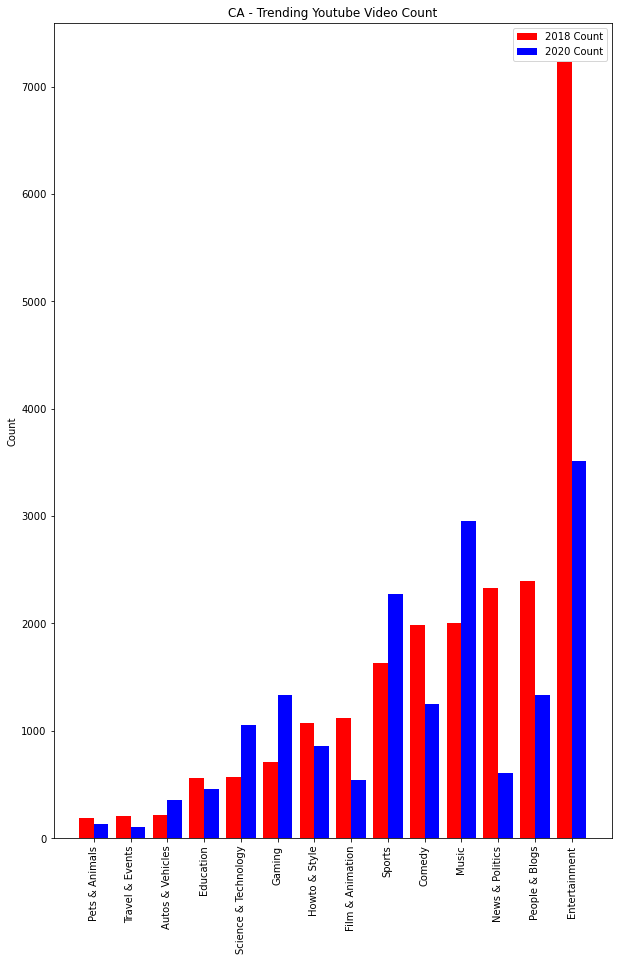

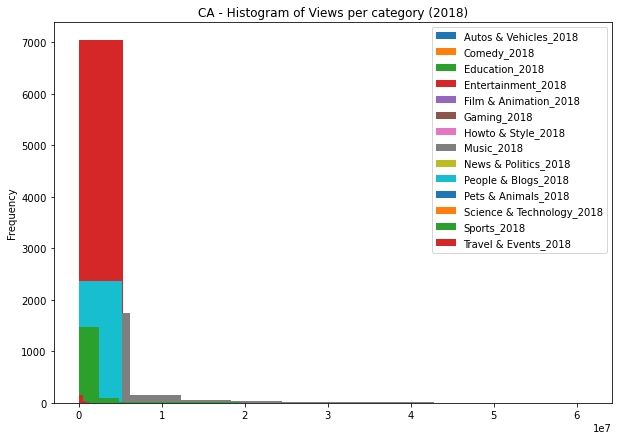

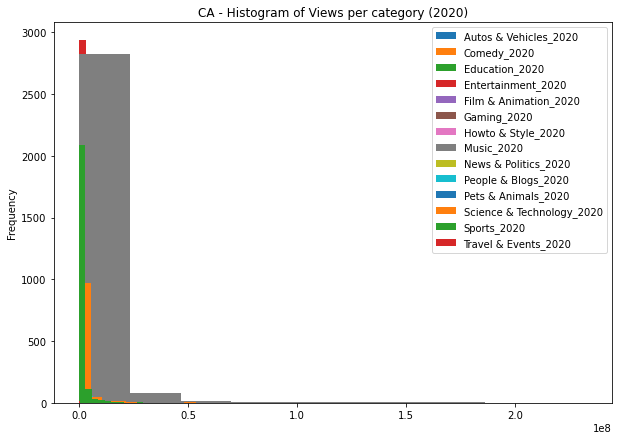

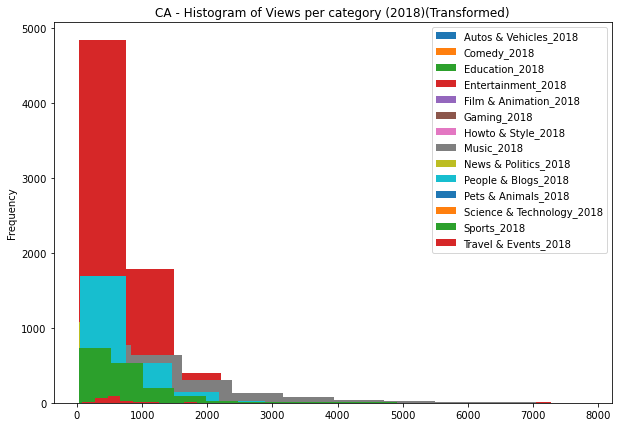

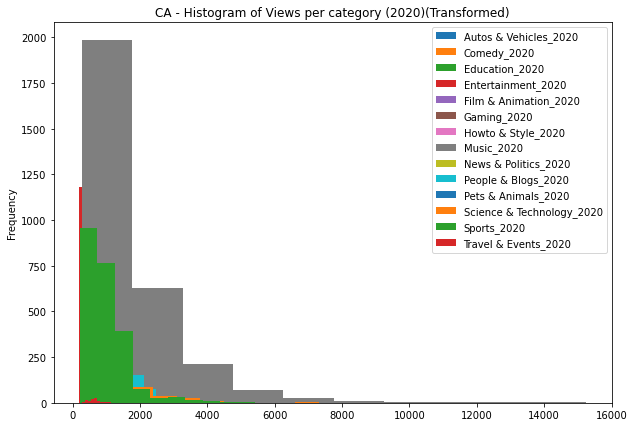

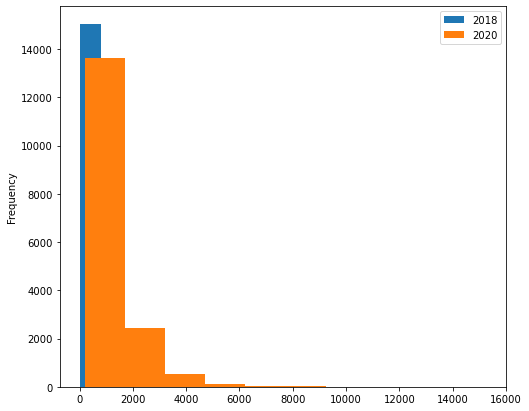

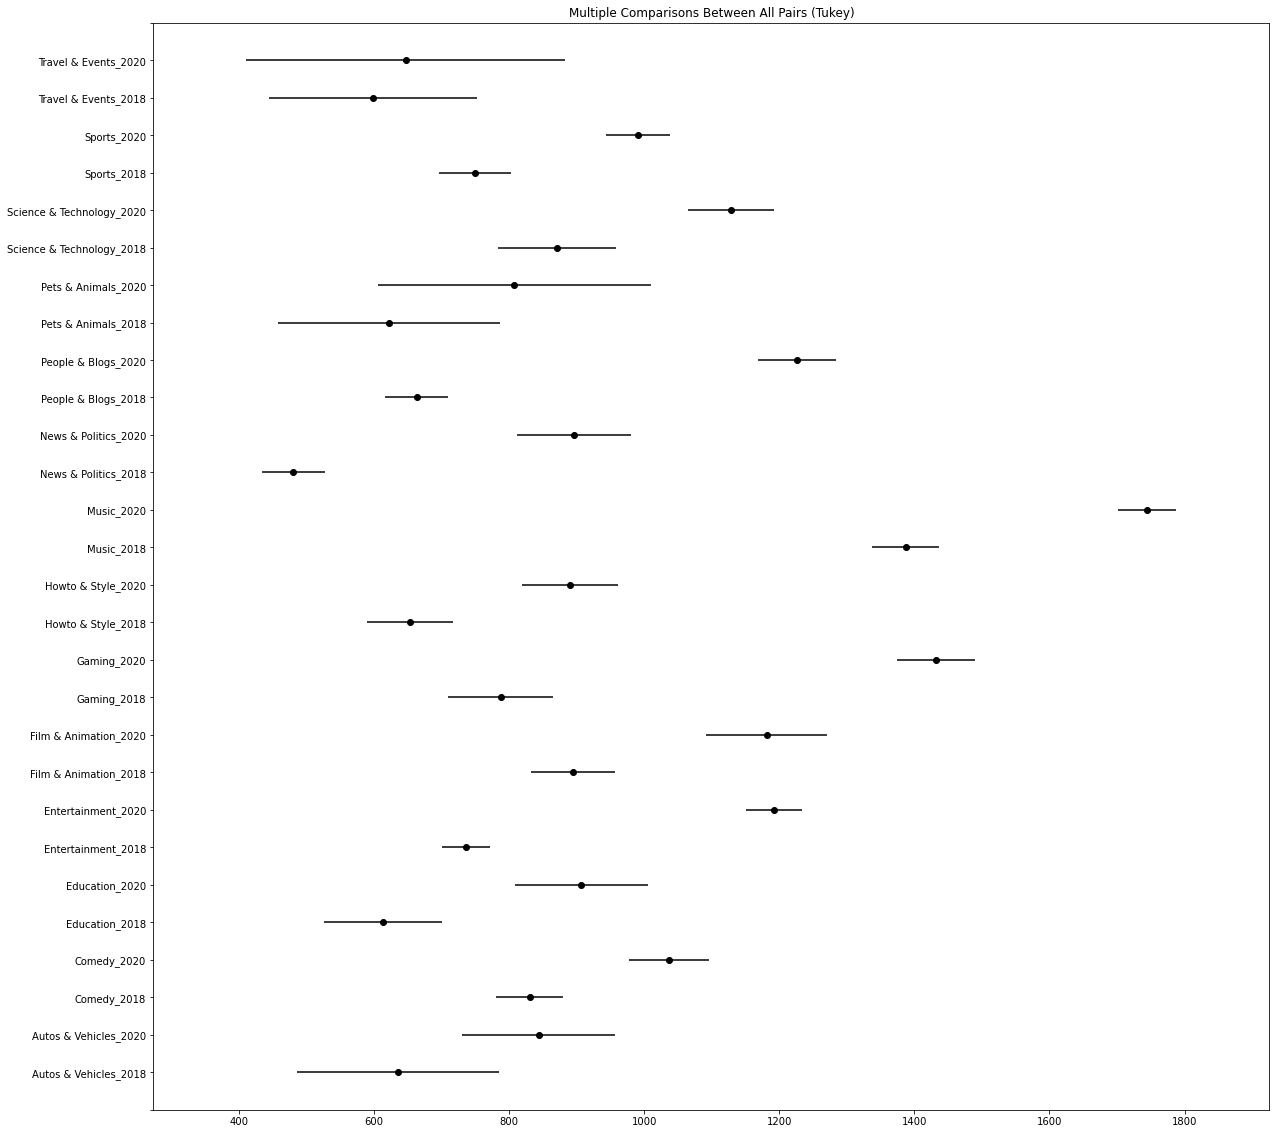

In [5]:
## SET THE COUNTRY OF YOUR CHOICE HERE ##
country = "CA" # CA or GB or US

# Print out a header
print('\n\n-> Starting Analysis for Trending YouTube Videos in ' + str(country) + '\n')    

# Print out calculation status report on screen
for i in range(21):
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*i, 5*i))
    sys.stdout.flush()
    sleep(0.1)   


### RETRIEVING + TRANSFORMING THE DATA ###


# Get the 2018 data for the input country
vids_2018_dir = './2018 Data/' + str(country) + 'videos' + '.csv.zip'
cats_2018_dir = './2018 Data/' + str(country) + '_category_id.json'
merged_2018_data = get_merged_data_2018(vids_2018_dir, cats_2018_dir)
merged_2018_data = merged_2018_data.sort_values('count')

# Get the 2020 data for the input country
vids_2020_dir = './2020 Data/' + str(country) + '_youtube_trending_data.csv.zip'
cats_2020_dir = './2020 Data/' + str(country) + '_category_id.json'
merged_2020_data = get_merged_data_2020(vids_2020_dir, cats_2020_dir)    
merged_2020_data = merged_2020_data.sort_values('count') 

# Merge all of the data together
all_data_merged = pd.merge(merged_2018_data, merged_2020_data, on=['cat_name'])
all_data_merged = all_data_merged.rename(columns={"count_x": "count_2018","count_y": "count_2020"})

# Create the barplot
create_barplot(all_data_merged, country)

# print the dataframe
print("\n\n-> The Trending Count per Category for 2018 and 2020:\n\n", all_data_merged, '\n')


### ANALYSIS: CHI-SQUARED TEST ###


# Create the contingency table
# columns -> 2018, 2020
# rows    -> video cateories
col1 = all_data_merged['count_2018'].astype(int).tolist()
col2 = all_data_merged['count_2020'].astype(int).tolist()
contingency_table = np.array([col1, col2], dtype=np.uint32)

# Contingency table used in Chi-Squared Analysis:
print('\n-> Contingency table used in Chi-Squared Analysis:')
print('\n2018 data:\n\n', col1, '\n')
print('\n2020 data:\n\n', col2, '\n')

# Perform a Chi Square Test on the table
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results of the chi-squared test
print('\n-> Chi Squared P-value for Wether or Not the Year had an Effect on the Category of Trending Videos:\n')
print(p, '\n')


### MORE DATA TRANSFORMATION ###


# Get view data from trending categories
views_per_cats_2018 = get_view_data_2018(vids_2018_dir, cats_2018_dir)
views_per_cats_2020 = get_view_data_2020(vids_2020_dir, cats_2020_dir)

# Get views of every trending video and extract the category and view count
views_per_cats_2018 = get_view_data_2018(vids_2018_dir, cats_2018_dir)
views_per_cats_2020 = get_view_data_2020(vids_2020_dir, cats_2020_dir)

# Keep rows that are in categories that are common to both years
categories_in_2018 = views_per_cats_2018['cat_name'].unique()
categories_in_2020 = views_per_cats_2020['cat_name'].unique()
common_cats = np.intersect1d(categories_in_2018, categories_in_2020)
views_per_cats_2018 = views_per_cats_2018[views_per_cats_2018['cat_name'].isin(common_cats)]
views_per_cats_2020 = views_per_cats_2020[views_per_cats_2020['cat_name'].isin(common_cats)]

# Label the data and combine
views_per_cats_2018['cat_name'] = views_per_cats_2018['cat_name'].astype(str) + '_2018'
views_per_cats_2020['cat_name'] = views_per_cats_2020['cat_name'].astype(str) + '_2020'


### NORMALITY TEST + TRANSFORMATIONS ###


# Plot Normal Plot of views in each category
plot_views_hist(views_per_cats_2018, country, 2018, 0)
plot_views_hist(views_per_cats_2020, country, 2020, 0)

# Perform Normality Test (Uncomment to see results)
#print('\n-> Normality Test For Views per Category\n')
#normality_test_views(views_per_cats_2018, country, 2018)
#normality_test_views(views_per_cats_2020, country, 2020)

# transform the data
views_per_cats_2018_trans = transform_views_data(views_per_cats_2018)
views_per_cats_2020_trans = transform_views_data(views_per_cats_2020)

# Plot Normal Plot of views in each category
plot_views_hist(views_per_cats_2018_trans, country, 2018, 1)
plot_views_hist(views_per_cats_2020_trans, country, 2020, 1)

# UNCOMMENT HERE TO SEE FULL TEST
#print('\n-> Normality Test for Transformed Views per Category\n')
#normality_test_views(views_per_cats_2018_trans, country, 2018)
#normality_test_views(views_per_cats_2020_trans, country, 2020)



### ANALYSIS: ANOVA ###

x1 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Film & Animation_2018']['views']
x2 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Music_2018']['views']
x3 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'News & Politics_2018']['views']
x4 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Pets & Animals_2018']['views']
x5 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Entertainment_2018']['views']
x6 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Education_2018']['views']
x7 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Howto & Style_2018']['views']
x8 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'People & Blogs_2018']['views']
x9 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Comedy_2018']['views']
x10 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Sports_2018']['views']
x11 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Science & Technology_2018']['views']
x12 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Travel & Events_2018']['views']
x13 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Autos & Vehicles_2018']['views']
x14 = views_per_cats_2018[views_per_cats_2018['cat_name'] == 'Gaming_2018']['views']

y1 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Film & Animation_2020']['views']
y2 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Music_2020']['views']
y3 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'News & Politics_2020']['views']
y4 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Pets & Animals_2020']['views']
y5 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Entertainment_2020']['views']
y6 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Education_2020']['views']
y7 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Howto & Style_2020']['views']
y8 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'People & Blogs_2020']['views']
y9 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Comedy_2020']['views']
y10 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Sports_2020']['views']
y11 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Science & Technology_2020']['views']
y12 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Travel & Events_2020']['views']
y13 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Autos & Vehicles_2020']['views']
y14 = views_per_cats_2020[views_per_cats_2020['cat_name'] == 'Gaming_2020']['views']

anova_results = stats.f_oneway(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14,
                               y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14) ## add x15 and y15 if using US

print('\n-> ANOVA p-value for Views of trending Views per each Year, Category pair\n')
print(anova_results[1])


### ANALYSIS: DIFFERENCE BETWEEN VIEWS PER YEAR ###


# append the data together
views_per_cats_2018['year'] = 2018
views_per_cats_2020['year'] = 2020
all_labeled_views_per_cats = views_per_cats_2018.append(views_per_cats_2020, ignore_index=True)

# Plot the total views for 2018 and 2020
plot_total_views_hist(all_labeled_views_per_cats, country)

# Perform a Mann-Whitney Test:
print('\n-> Mann-Whitney Test P-Value for Views of Trending Videos in 2018 and 2020')
mann_whit_test = stats.mannwhitneyu(views_per_cats_2018['views'], views_per_cats_2020['views'], alternative='two-sided')[1]
print('\n' + str(mann_whit_test) + '\n')


### ANALYSIS: TUKEYS FOR CATEGORIES BETWEEN EACH YEAR ###

# Tukey's Analysis per category
posthoc = pairwise_tukeyhsd(
        all_labeled_views_per_cats['views'], 
        all_labeled_views_per_cats['cat_name'],
        alpha=0.05)

# UNCOMMENT HERE TO SEE FULL POSTHOC
#print('\n-> PostHoc Analysis for Views Per Categories for 2018 vs 2020:\n')
#print(posthoc)

# Save Tukey's data
fig = posthoc.plot_simultaneous()    
fig.set_size_inches(20, 20)
title = str(country) + ' - Tukeys Test per Categories of 2018 and 2020.png'
fig.savefig(title)

# Print end line
print('\n  -> Analysis Complete <-  \n')